In [1]:
import os, sys, time, math
import tensorflow as tf
# import tensorlayer as tl
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import cv2
# import network, img_io


## 1. Import LDR images 
these HDR images are derived from HDR image dataset from google. 
the code used for this procedure is function from MATLAB


### X: LDR images,  the hdrcnn simulated LDR
### y: True LDR images, from Matlab, or HDR images

In [2]:
def Extract_Filenames(dirpath):
    """Get all the filenames of .csv in the given directory
    Args:
        dirpath(string): the directory to search for the files.
    Returns:
        list: a list of filenames
    """

    import glob
#     dirpath = './test_data/'
    file_lst = [f for f in glob.glob("{}*.jpg".format(dirpath))]
    file_lst = [file_lst[i].split('\\')[-1].split('/')[-1]
                for i in range(len(file_lst))]
    file_lst = sorted(file_lst)
    return file_lst

In [8]:
def import_images(dirpath = './LDR data/'):
    # read data from <data> folder
    filenames = Extract_Filenames(dirpath)
    X = np.zeros((len(filenames), 1000, 1000))
    i=0   
    for name in filenames:
        image = cv2.imread(dirpath+name)
        x, y = abs(500*np.random.randn(2,1)).astype(np.int)
        x, y = x[0], y[0]
        image = image[y:y+1000, x:x+1000]
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # turn into grayscale
        X[i,:,:] = gray
        i +=1
    return X

In [9]:
# X: simulated LDR images 152, 1208, 768, 3
# y: ground truth HDR images, 152, 4208 3120 3

X = import_images(dirpath = './LDR data/')
X.shape
y = import_images(dirpath = './HDR data/')
y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

(149, 1000, 1000)
(149, 1000, 1000)
(4, 1000, 1000)
(4, 1000, 1000)


In [12]:
sx,sy = X_train[0].shape
sz= 1
sx,sy,sz

(1000, 1000, 1)

## 3. create input pipeline for generating training/testing batches

In [26]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, sx,sy], name='input_LDR')
y_train_or_test = tf.placeholder(tf.float32, [None, sx,sy], name='ground_truth_HDR')

batch_size = 4

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)

batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [27]:
X_batch

<tf.Tensor 'IteratorGetNext_1:0' shape=(?, 1000, 1000) dtype=float32>

## 4. create three pixel-level filters 

In [30]:
train_filters_1,train_filters_2,train_filters_3 = True,True,True

input_filter_1 = tf.Variable(np.ones([sx,sy]), dtype=tf.float32, trainable=train_filters_1)
input_filter_2 = tf.Variable(np.ones([sx,sy]), dtype=tf.float32, trainable=train_filters_2)
input_filter_3 = tf.Variable(np.ones([sx,sy]), dtype=tf.float32, trainable=train_filters_3)

In [31]:
input_filter_1

<tf.Variable 'Variable_6:0' shape=(1000, 1000) dtype=float32_ref>

## 5. generate the filtered images


In [32]:
X_filtered_1 = tf.multiply(X_batch, input_filter_1)
X_filtered_2 = tf.multiply(X_batch, input_filter_2)
X_filtered_3 = tf.multiply(X_batch, input_filter_3)

In [33]:
X_filtered_1

<tf.Tensor 'Mul_3:0' shape=(?, 1000, 1000) dtype=float32>

## 6. propagate back to the image plane: filtered LDR 


In [34]:
image_1 = tf.abs(X_filtered_1)**2
image_2 = tf.abs(X_filtered_2)**2
image_3 = tf.abs(X_filtered_3)**2

# add noise:
image_1 += tf.random.normal([sx,sy], mean=0, stddev=0.05)
image_2 += tf.random.normal([sx,sy], mean=0, stddev=0.05)
image_3 += tf.random.normal([sx,sy], mean=0, stddev=0.05)

In [35]:
image = (image_1 + image_2 + image_3)/3
image

<tf.Tensor 'truediv_1:0' shape=(?, 1000, 1000) dtype=float32>

 ## 7. process the filtered image through a Physical CNN to optimize filters

- ### Pass through Digital layer to get HDR output image.
- ### use the same loss as the Digital layer. 
loss is illumination + reflectance loss
I just need revise the hdrcnn_predict.py into a function, which return the HDR image and the loss?

revise get_final to return not only the HDR imgae, but also the cost. 

or should I define my own loss? 

FLAGS.sep_loss is the flag to separate loss into illumination and reflectance


### procedures problems? 

how about another loss? the filter does not have the same loss as the HDR images. 
I can define a loss, and train the network, then feed all the images to the Network, I don't need to change HDRCNN at all. 
just feed the processed LDR* images to the HDRCNN in one folder. 

# need to test, the tone mapping pic is better.

### Define Cost function

In [ ]:
# this is from precious TA sessuion
net_input_layer = image[..., None]  # add a channels dimension
net_input_layer

# define your CNN here
net = net_input_layer

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)


# add some more if you want:
net = tf.layers.conv2d(net, filters=256, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=256, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.dropout(net, 0.5)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

net = tf.layers.conv2d(net, filters=512, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=512, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.dropout(net, 0.5)

net = tf.layers.conv2d(net, filters=256, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=256, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.dropout(net, 0.5)

net = tf.layers.conv2d(net, filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu)

net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)

net = tf.layers.conv2d(net, filters=2, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=1, kernel_size=1, activation=tf.nn.sigmoid)


loss = tf.reduce_sum(tf.image.total_variation(y_batch- net))/1000/1000

In [37]:
train_op = tf.train.AdamOptimizer(.01).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## 8. Train

In [38]:
def plot_examples(batch):
    plt.figure(figsize=(30, 30))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()

In [39]:
# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

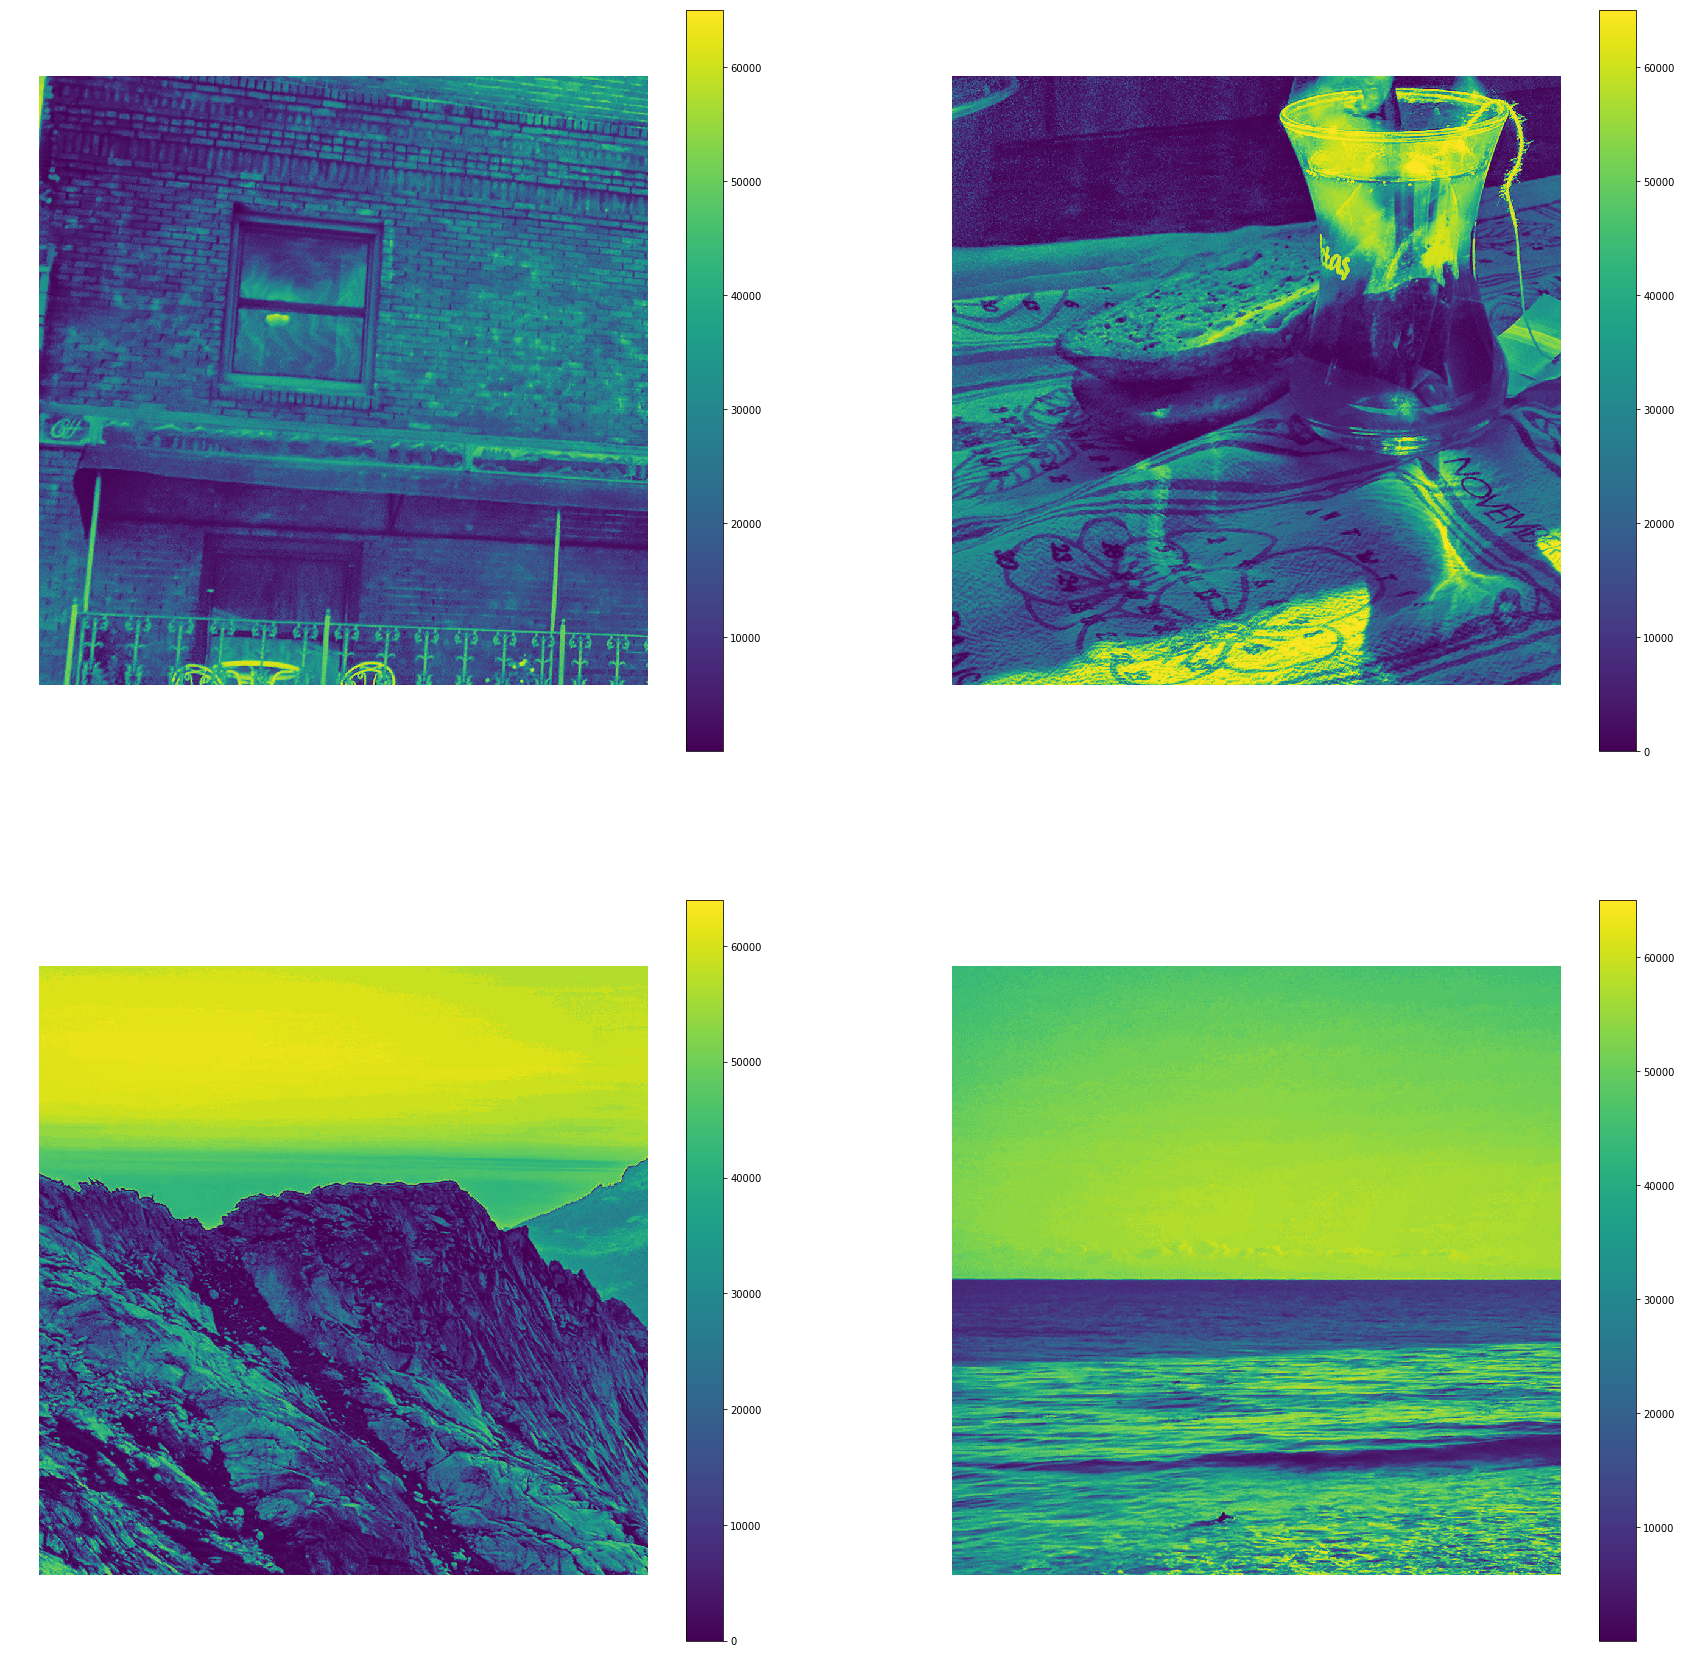

In [40]:
plot_examples(image.eval())

In [ ]:
losses = list()
# if you get a noninvertible error, try decreasing your learning rate
for i in range(10000):
    loss_i, _ = sess.run([loss, train_op])
    losses.append(loss_i)
    if i %1000 == 0:
        print(loss_i)

In [ ]:
# train loop:
for i in range(3000):
    _, loss_i = sess.run([train_op, loss])
    if (i+1)%100 == 0:
        print('loss', i+1,':', loss_i)

In [44]:
# plot examples after the training
# plot_examples(image.eval())

In [45]:
input_filter_1.eval()
input_filter_2.eval()
input_filter_3.eval()

array([[ 0.03630399,  0.03492905,  0.0373841 , ...,  0.03246253,
         0.03158865,  0.03385535],
       [ 0.03883664,  0.03664777,  0.03393989, ...,  0.04061241,
         0.03308909,  0.03725617],
       [ 0.03924548,  0.03786309,  0.03455634, ...,  0.03940439,
         0.03223991,  0.03720113],
       ...,
       [ 0.01080893, -0.01781494,  0.00931775, ...,  0.00085296,
        -0.01262501,  0.00525969],
       [ 0.0048214 , -0.01985931,  0.01072116, ...,  0.00138833,
        -0.00893824,  0.00298611],
       [ 0.01257844, -0.0205526 , -0.00643346, ...,  0.01055615,
        -0.01011564, -0.00565652]], dtype=float32)

## 9. Results

In [ ]:
def compare_results():
    """plot:
    simulated_LDR
    simulated_HDR AFTER training
    simulated_HDR BEFORE training    
    ground_truth_HDR
    
    """ 
    
    pass